In [13]:
# ! pip install pandas numpy matplotlib rasterio dotenv

# ! pip freeze > ../requirements.txt

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load Evnvironment

In [15]:
load_dotenv(".env")

ROOT_DATA_DIR = "../data" #os.getenv("ROOT_DATA_DIR")
CACHE_DIR = os.getenv("CACHE_DIR")

# Constants

In [16]:
CUT_OFF = 0.01

In [17]:
CACHE_DIR = f"{ROOT_DATA_DIR}{os.sep}{CACHE_DIR}"

LANDCOVER_GROWTH_2006_2010 = f"{CACHE_DIR}{os.sep}landcover_canada_growth_after_2005_to_2010_fire_in_2010.csv"
LANDCOVER_GROWTH_2011_2015 = f"{CACHE_DIR}{os.sep}landcover_canada_growth_after_2010_to_2015_fire_in_2015.csv"
LANDCOVER_GROWTH_2016_2020 = f"{CACHE_DIR}{os.sep}landcover_canada_growth_after_2015_to_2020_fire_in_2020.csv"
LANDCOVER_GROWTH = [
    LANDCOVER_GROWTH_2006_2010,
    LANDCOVER_GROWTH_2011_2015,
    LANDCOVER_GROWTH_2016_2020,
]

LANDCOVER_COUNT_2010 = f"{CACHE_DIR}{os.sep}landcover_canada_count_2010.csv"
LANDCOVER_COUNT_2015 = f"{CACHE_DIR}{os.sep}landcover_canada_count_2015.csv"
LANDCOVER_COUNT_2020 = f"{CACHE_DIR}{os.sep}landcover_canada_count_2020.csv"
LANDCOVER_COUNT = [
    LANDCOVER_COUNT_2010,
    LANDCOVER_COUNT_2015,
    LANDCOVER_COUNT_2020
]

YEARS = [
    2010,
    2015,
    2020
]

In [18]:
LANDCOVER_COLORS = {
    0:"#FFFFFF",
    1:"#1B5E20", 
    2:"#689F38", 
    3:"#9CCC65", 
    4:"#C5E1A5", 
    5:"#66BB6A", 
    6:"#004D40", 
    7:"#A5D6A7", 
    8:"#808000",
    9:"#005000", 
    10:"#2E7D32", 
    11:"#00897B", 
    12:"#004D40", 
    13:"#B2DFDB", 
    14:"#4DB6AC", 
    15:"#795548", 
    16:"#808080", 
    17:"#000000", 
    18:"#000080", 
    19:"#D0D0F0"
}

In [19]:
LANDCOVER_LABELS = {
    0: "Not Canada",
    1: "Temperate or Sub-Polar Needleleaf Forest",
    2: "Sub-Polar Taiga Needleleaf Forest",
    3: "3 - No Name Yet",
    4: "4 - No Name Yet",
    5: "Temperate or Sub-Polar Broadleaf Deciduous Forest",
    6: "Mixed Forest",
    7: "7 - No Name Yet",
    8: "Temperate or Sub-Polar Shrubland",
    9: "9 - No Name Yet",
    10: "Temperate or Sub-Polar Grassland",
    11: "Sub-Polar or Polar Shrubland-Lichen-Moss",
    12: "Sub-Polar or Polar Grassland-Lichen-Moss",
    13: "Sub-Polar or Polar Barren-Lichen-Moss",
    14: "Wetland",
    15: "Cropland",
    16: "Baren Land",
    17: "Urban building",
    18: "Water",
    19: "Snow and Ice"
}

# Helper Functions

In [20]:
def get_year_df(
    landcover_count_file:str,
    landcover_growth_file:str,
    index_col_count:str = "ID",
    index_col_growth:str = "ID",
    grown_transparency:str = "AA",
    color_dict:dict = LANDCOVER_COLORS,
    label_dict:dict = LANDCOVER_LABELS,
    cut_off:float = CUT_OFF,
):
    # read daat
    landcover_count_df = pd.read_csv(
        landcover_count_file,
        index_col = index_col_count
    )
    landcover_growth_df = pd.read_csv(
        landcover_growth_file,
        index_col = index_col_growth
    )

    # merge data
    landcover_growth_year_df = pd.merge(
        left = landcover_count_df,
        right = landcover_growth_df,
        right_index = True,
        left_index = True,
        suffixes = ['_TOTAL', '_GROWN']
    )
    del landcover_growth_df
    del landcover_count_df

    # reset index to have ids
    landcover_growth_year_df.reset_index(
        inplace = True
    )

    # add color and label data 
    landcover_growth_year_df["COLOR"] = landcover_growth_year_df[index_col_count].apply(lambda id: color_dict[id])
    landcover_growth_year_df["COLOR_GROWN"] = landcover_growth_year_df[index_col_count].apply(lambda id: f"{color_dict[id]}{grown_transparency}")
    landcover_growth_year_df["LABEL"] = landcover_growth_year_df[index_col_count].apply(lambda id: label_dict[id])

    # add grown percent
    landcover_growth_year_df["GROWN_PERCENT"] = landcover_growth_year_df.apply(
        lambda row: row['COUNT_GROWN'] / row['COUNT_TOTAL'] if row['COUNT_TOTAL'] != 0 else 0,
        axis = 1
    )

    # discard water bodies
    landcover_growth_year_df = landcover_growth_year_df[landcover_growth_year_df["ID"] != 18]

    # drop values less than cut off
    landcover_growth_year_df = landcover_growth_year_df[landcover_growth_year_df['COUNT_TOTAL'] > landcover_growth_year_df['COUNT_TOTAL'].max() * cut_off]

    return landcover_growth_year_df

In [21]:
def plot_growth_after_burn_donut(
    landcover_df,
    year:int,
    fig_name:str,
    title:str = "",
    donut_width:float = 0.5,
    start_angle:float = 0,
    figsize:tuple = (10, 10),
    year_font_size = 20,
    total_col:str = "COUNT_TOTAL",
    color_inner_col:str = "COLOR",
    color_outer_col:str = "COLOR_GROWN",
    id_col:str = "ID",
    label_col:str = "LABEL",
    growth_percent_col:str = "GROWN_PERCENT"
):
    fig, ax = plt.subplots(
        figsize = figsize
    )

    # plot all land cover segments
    ax.pie(
        landcover_df[total_col], 
        radius = 1, 
        startangle = start_angle,
        colors = landcover_df[color_outer_col],
        # labels = landcover_df[label_col],
        # labels = landcover_df[id_col],
        wedgeprops = dict(
            width = donut_width, 
        ),
    )

    # plot non burnt are donut
    wedges, texts, _percent = ax.pie(
        landcover_df[total_col], 
        radius = 1, 
        startangle = start_angle,
        colors = landcover_df[color_outer_col],
        wedgeprops = dict(
            width = donut_width, 
        ),
        autopct=''
        # autopct='%0.2f%%'
    )

    # add inicators to side
    kw = dict(
        arrowprops = dict(arrowstyle="-"),
        bbox = dict(
            boxstyle=f"square,pad={donut_width}", 
            fc = 'w', 
            ec = 'w', 
            lw = 0.5 
        ), 
        zorder = 0, 
        va="center"
    )

    # add year label
    ax.text(
        x = 0,
        y = 0,
        s = f"{year}\nLand Cover\n\n\nHistoric Fires\n{year-4}-{year}",
        fontsize = year_font_size,
        fontweight = 'bold',
        va = 'center',
        ha = 'center',
    )

    for i, p in enumerate(wedges):
        # add extra height for burnt area
        p.set_width(
            donut_width - landcover_df[growth_percent_col].iloc[i] * donut_width
        )

        # get percent of land 
        percent = (p.theta2 - p.theta1) / 360 * 100

        # add and labels
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

        connectionstyle = f"angle,angleA=0,angleB={ang}"
        
        kw["bbox"].update({"fc": f"{landcover_df[color_inner_col].iloc[i]}55"})
        kw["arrowprops"].update({"connectionstyle": connectionstyle})

        ax.annotate(
            # texts[i].get_text(), # add lables only if plotting with lables 
            f"{landcover_df[id_col].iloc[i]}: {percent:.1f}% of land area, {(landcover_df[growth_percent_col].iloc[i]*100):0.1f}% grown after fire", # add lables 
            xy = (x, y), 
            xytext = (1.2*np.sign(x), 1.2*y),
            fontsize = 15,
            horizontalalignment = horizontalalignment, 
            **kw
        )

    plt.savefig(
        fig_name, 
        transparent = True,
        bbox_inches = 'tight', # compress the content  
        pad_inches = 0, # have no extra margin
    )


    # add title
    if title == "":
        title = f"Land Cover {year} for Historic Fires {year-4}-{year}"
    ax.set_title(title)
    
    plt.show()
    

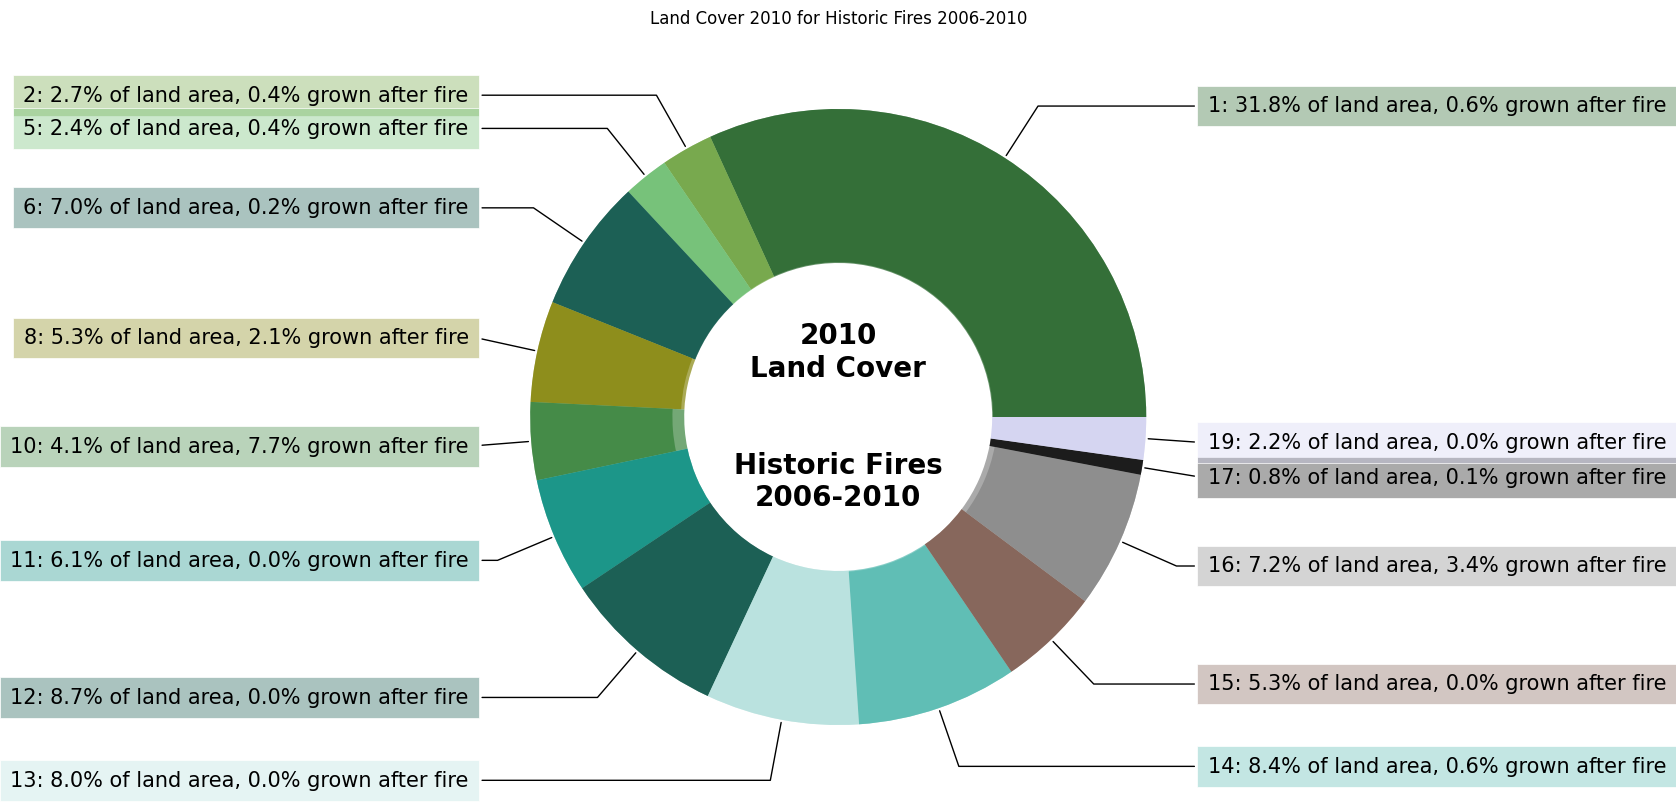

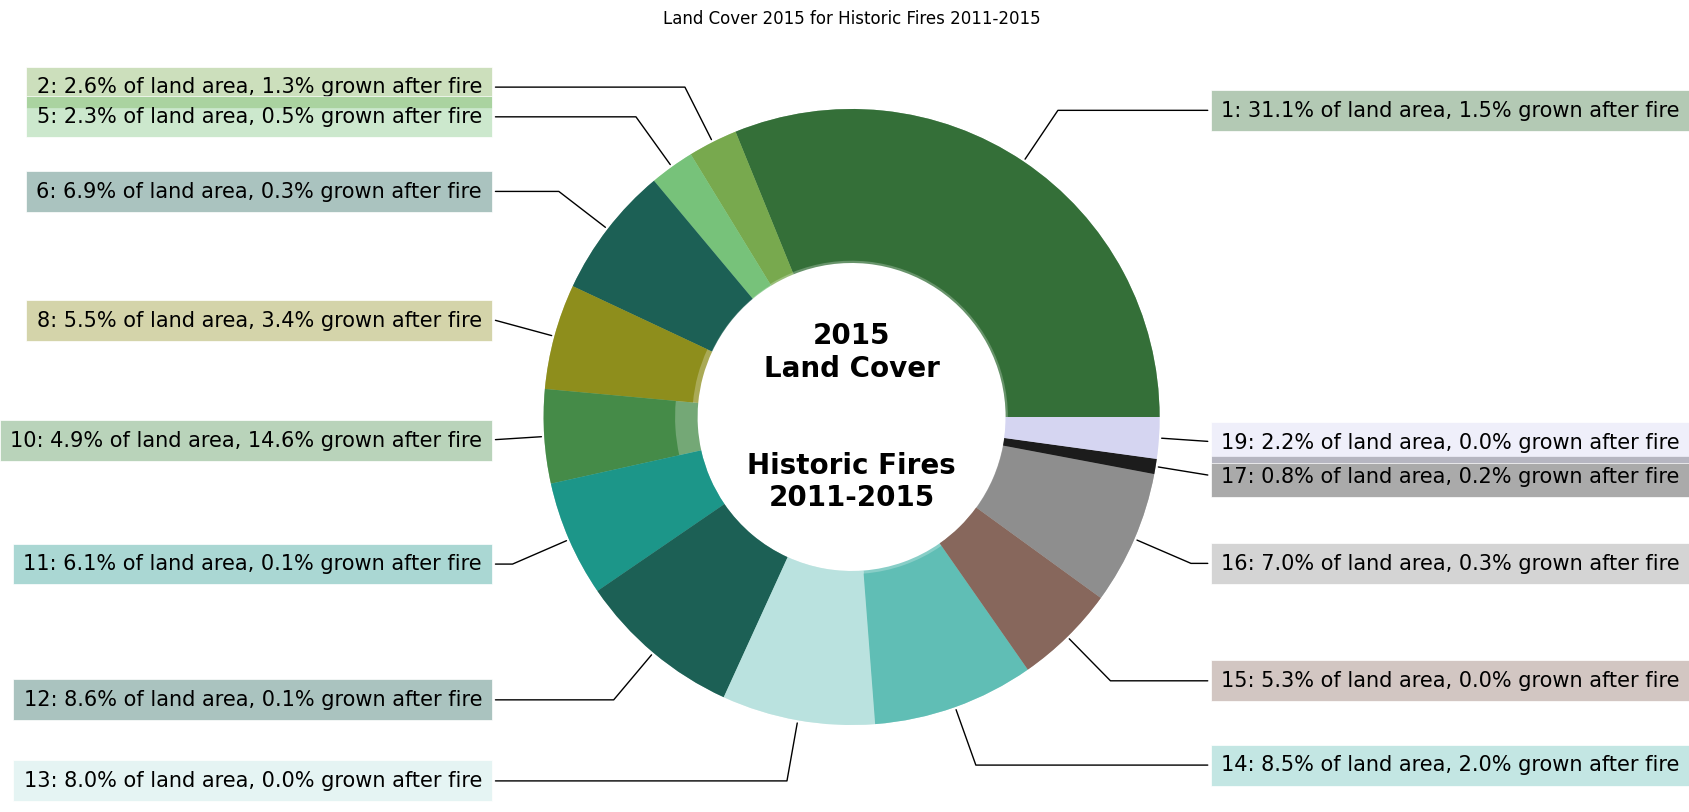

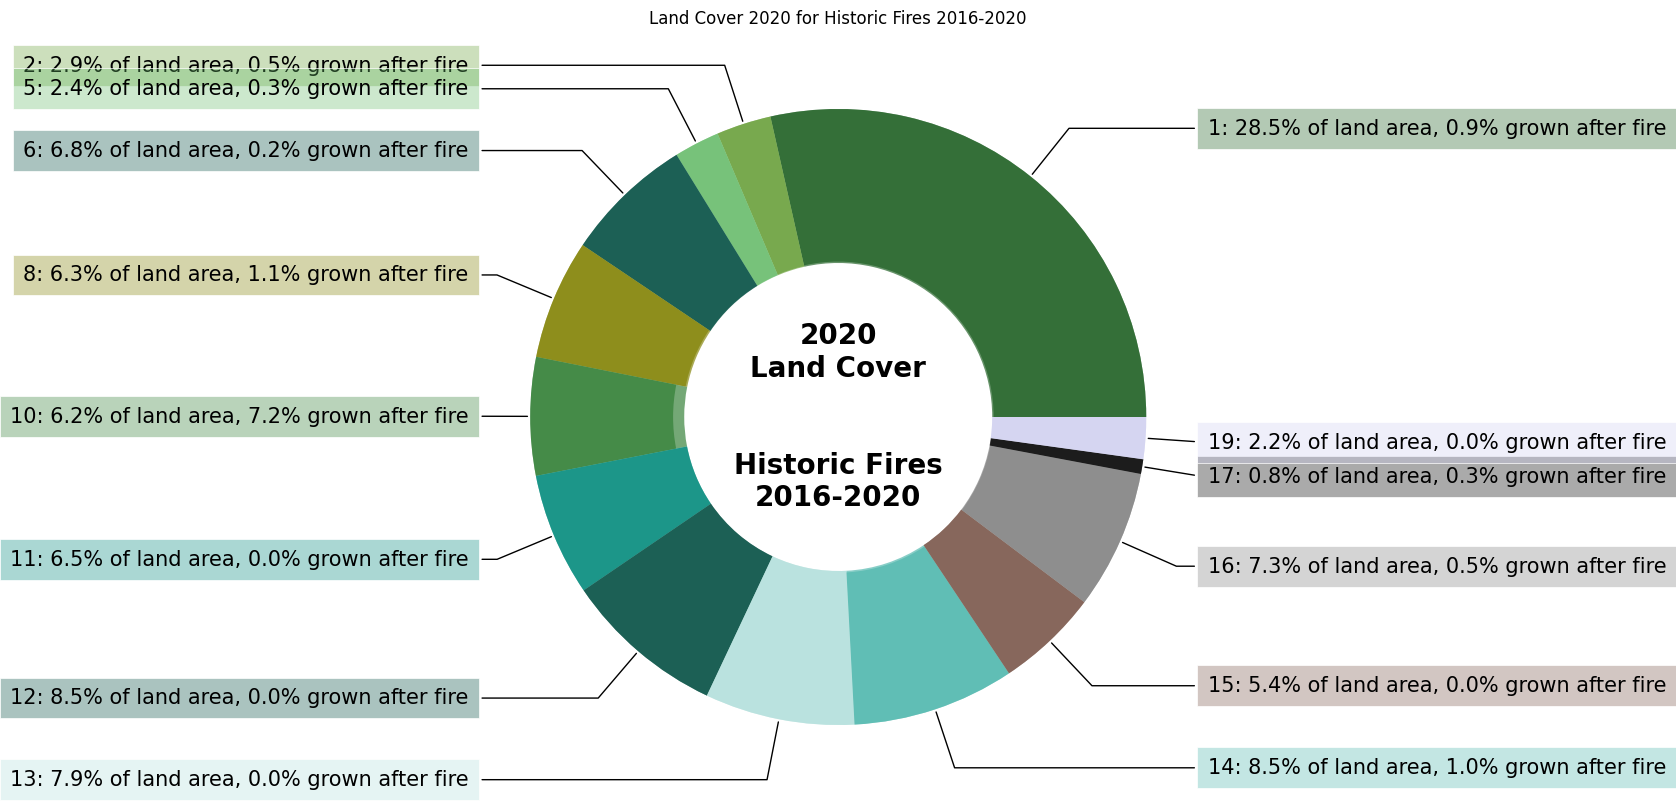

In [22]:
for growth_file, count_file, year in zip(LANDCOVER_GROWTH, LANDCOVER_COUNT, YEARS):
    df = get_year_df(
        landcover_growth_file = growth_file,
        landcover_count_file = count_file
    )

    plot_growth_after_burn_donut(
        landcover_df = df,
        year = year,
        fig_name = f"../assets/figures/landcover_canada_grown_{year}_historic_fire_{year-4}_{year}.png"
    )